# Track Energy

Notebook to track energy throughout the car to analyze energy discrepancies and if sensor calibration is needed

## Imports and Init

In [1]:
from data_tools.time_series import TimeSeries
from data_tools.influx_client import InfluxClient
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np

# Start and stop dates/times to query from Influx
# NOTE: TIMES SHOULD BE IN UTC
start = "2024-07-18T17:00:00Z"
stop = "2024-07-18T21:00:00Z"

# Parameters for Savitsky-Golav filter. SEE https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html#scipy.signal.savgol_filter
WINDOW_SIZE = 20
POLYNOMIAL_ORDER = 2

client = InfluxClient()

### Necessary Functions 
Functions to align **TimeSeries** objects and get signed battery current, pack power, and motor power.

In [2]:
def get_signed_battery_current(battery_current_direction: TimeSeries, battery_current: TimeSeries) -> TimeSeries:
    # Ensure that the input time series are aligned before multiplication
    battery_current_direction, battery_current = TimeSeries.align(battery_current_direction, battery_current)

    # Convert direction to be -1 or 1 for scalar multiplication
    masked_direction = np.where(battery_current_direction == 0, 1, -1)
    
    signed_current_data = masked_direction * battery_current

    # Create the metadata for the signed current TimeSeries
    signed_current_meta = {
        "start": battery_current_direction.start,
        "stop": battery_current_direction.stop,
        "car": battery_current_direction.meta["car"],
        "measurement": battery_current_direction.meta["measurement"],
        "field": "SignedBatteryCurrent",
        "granularity": battery_current_direction.granularity,
        "length": battery_current_direction.length,
        "units": "A",
    }

    # Create and return the new TimeSeries object
    signed_current = TimeSeries(signed_current_data, signed_current_meta)
    return signed_current

def get_power(current: TimeSeries, voltage: TimeSeries, new_field_name: str, units: str) -> TimeSeries:
    # Ensure that the input time series are aligned before multiplication
    current, voltage = TimeSeries.align(current, voltage)
    
    power_data = current * voltage

    # Create the metadata for the power TimeSeries
    power_meta = {
        "start": voltage.start,
        "stop": voltage.stop,
        "car": voltage.meta["car"],
        "measurement": voltage.meta["measurement"],
        "field": new_field_name,
        "granularity": voltage.granularity,
        "length": voltage.length,
        "units": units,
    }

    # Create and return the new TimeSeries object
    power = TimeSeries(power_data, power_meta)
    return power

## Setup
Query and fetch necessary data from Influx then calculate power from current and voltage, and analyze power plots from components 

In [3]:
# Battery Queries
battery_current: TimeSeries = client.query_time_series(start=start, stop=stop, field="BatteryCurrent", units="A")
battery_voltage: TimeSeries = client.query_time_series(start=start, stop=stop, field="BatteryVoltage", units="V")
battery_current_direction: TimeSeries = client.query_time_series(start=start, stop=stop, field="BatteryCurrentDirection")

C:\Users\tamze\OneDrive\Documents\GitHub\data_analysis\.venv\Lib\site-packages\data_tools\time_series.py:298: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "car": query_df["car"][0],
C:\Users\tamze\OneDrive\Documents\GitHub\data_analysis\.venv\Lib\site-packages\data_tools\time_series.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "measurement": query_df["_measurement"][0],
C:\Users\tamze\OneDrive\Documents\GitHub\data_analysis\.venv\Lib\site-packages\data_tools\time_series.py:298: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treate

In [4]:
# Pack Queries
pack_current: TimeSeries = client.query_time_series(start=start, stop=stop, field="PackCurrent", units="A")
pack_voltage: TimeSeries = client.query_time_series(start=start, stop=stop, field="TotalPackVoltage", units="V")

C:\Users\tamze\OneDrive\Documents\GitHub\data_analysis\.venv\Lib\site-packages\data_tools\time_series.py:298: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "car": query_df["car"][0],
C:\Users\tamze\OneDrive\Documents\GitHub\data_analysis\.venv\Lib\site-packages\data_tools\time_series.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "measurement": query_df["_measurement"][0],
C:\Users\tamze\OneDrive\Documents\GitHub\data_analysis\.venv\Lib\site-packages\data_tools\time_series.py:298: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treate

In [5]:
# Array/AMB queries
amb_volt1: TimeSeries = client.query_time_series(start=start, stop=stop, field="VoltSensor1", units="V")
amb_volt2: TimeSeries = client.query_time_series(start=start, stop=stop, field="VoltSensor2", units="V")
amb_curr1: TimeSeries = client.query_time_series(start=start, stop=stop, field="CurrentSensor1", units="A")
amb_curr2: TimeSeries = client.query_time_series(start=start, stop=stop, field="CurrentSensor2", units="A")

C:\Users\tamze\OneDrive\Documents\GitHub\data_analysis\.venv\Lib\site-packages\data_tools\time_series.py:298: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "car": query_df["car"][0],
C:\Users\tamze\OneDrive\Documents\GitHub\data_analysis\.venv\Lib\site-packages\data_tools\time_series.py:299: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "measurement": query_df["_measurement"][0],
C:\Users\tamze\OneDrive\Documents\GitHub\data_analysis\.venv\Lib\site-packages\data_tools\time_series.py:298: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treate

Get power from fetched data

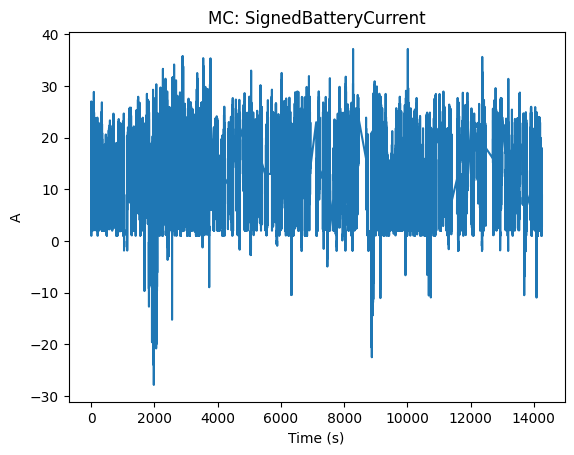

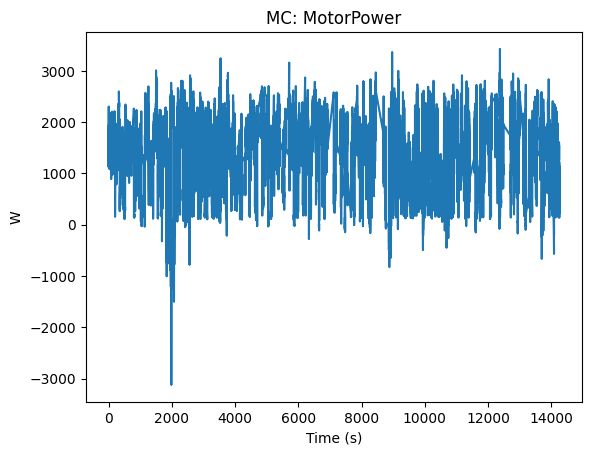

Filtered Motor Power:  [1299.79518736 1420.62559878 1528.94627844 ...  687.31950178  748.00528065
  813.27310748]


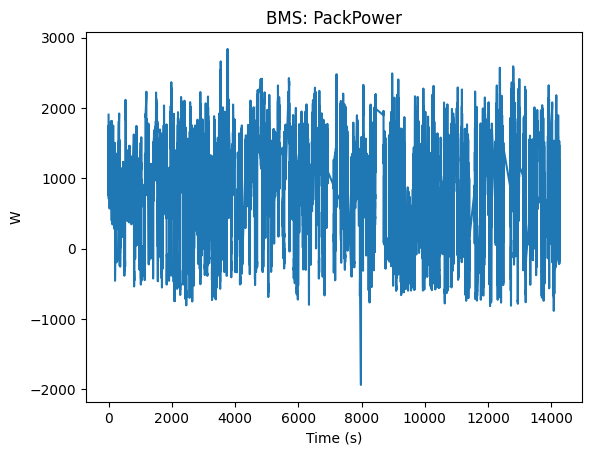

Filtered Pack Power:  [1904.29638838 1786.95846215 1675.79262515 ...  130.30735675  225.62072605
  333.829932  ]


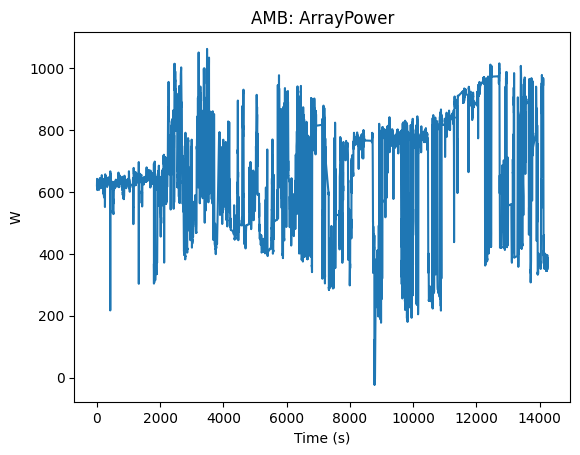

Filtered Array Power:  [621.09822878 621.60942764 622.07972123 ... 374.52379404 374.34398262
 374.21639615]


In [6]:
# Get signed battery current
signed_current = get_signed_battery_current(battery_current_direction, battery_current)
signed_current.plot()
# Get power
motor_power = get_power(signed_current, battery_voltage, "MotorPower", "W")
pack_power = get_power(pack_current, pack_voltage, "PackPower", "W")
array_power1 = get_power(amb_curr1, amb_volt1, "ArrayPower1", "W")
array_power2 = get_power(amb_curr2, amb_volt2, "ArrayPower2", "W")

# Get total power from arrays
array_power_data = array_power1 + array_power2

# Create the metadata for the power TimeSeries
array_power_meta = {
    "start": array_power1.start,
    "stop": array_power1.stop,
    "car": array_power1.meta["car"],
    "measurement": array_power1.meta["measurement"],
    "field": "ArrayPower",
    "granularity": array_power1.granularity,
    "length": array_power1.length,
    "units": array_power1.units,
}

# Create and return the new TimeSeries object
array_power = TimeSeries(array_power_data, array_power_meta)

# Clean data
filtered_motor_power = motor_power.promote(signal.savgol_filter(motor_power, WINDOW_SIZE, POLYNOMIAL_ORDER))
filtered_pack_power = pack_power.promote(signal.savgol_filter(pack_power, WINDOW_SIZE, POLYNOMIAL_ORDER))
filtered_array_power = array_power.promote(signal.savgol_filter(array_power, WINDOW_SIZE, POLYNOMIAL_ORDER))

# Visualize
filtered_motor_power.plot()
print("Filtered Motor Power: ", filtered_motor_power)
filtered_pack_power.plot()
print("Filtered Pack Power: ", filtered_pack_power)
filtered_array_power.plot()
print("Filtered Array Power: ", filtered_array_power)

## Analysis
The assumption is that **Pack Power = Motor Power - Array Power**, take the difference between *Motor Power* and *Array Power* and plot the observed discrepencies with *Pack Power*

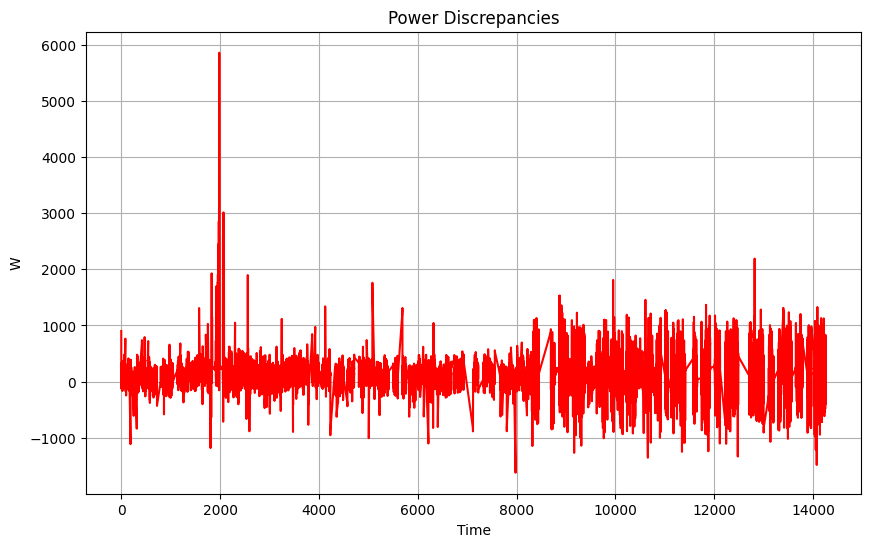

[902.04826256 701.79900599 520.19040423 ...  97.02321837 170.23466035
 264.40039705]
Mean Power Discrepancy:  117.01945477857721


In [7]:
# Get the deficit in power then get the discrepancy
filtered_motor_power, filtered_array_power = TimeSeries.align(filtered_motor_power, filtered_array_power)
deficit = filtered_motor_power - filtered_array_power 

filtered_pack_power, deficit = TimeSeries.align(filtered_pack_power, deficit)
discrepancy = filtered_pack_power - deficit

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(discrepancy.x_axis, discrepancy, color='red', linestyle='-')

# Add titles and labels
plt.title('Power Discrepancies')
plt.xlabel('Time')
plt.ylabel('W')

# Add grid lines
plt.grid(True)

# Show the plot
plt.show()

print(discrepancy)
print("Mean Power Discrepancy: ", np.mean(discrepancy))

<Figure size 1000x600 with 0 Axes>

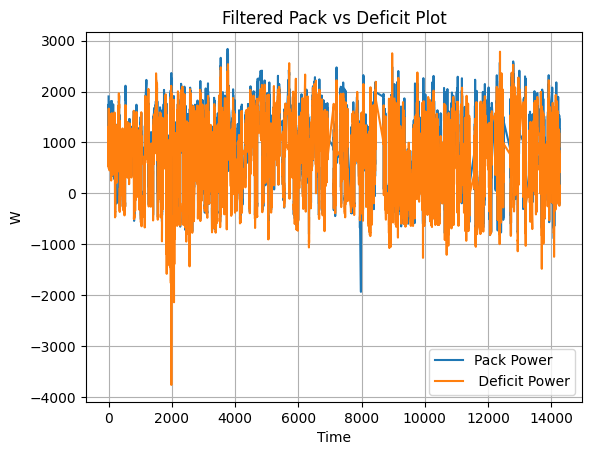

In [8]:
# Create the plot
plt.figure(figsize=(10, 6))

fig, ax = plt.subplots()
ax.plot(filtered_pack_power.x_axis, filtered_pack_power, label="Pack Power")
ax.plot(filtered_pack_power.x_axis, deficit, label=" Deficit Power")

# Add titles and labels
plt.title('Filtered Pack vs Deficit Plot')
plt.xlabel('Time')
plt.ylabel('W')

plt.grid(True)
plt.legend()

# Show the plot
plt.show()

**Ratio** between **pack power** and **discrepancy**, filtered and unfiltered

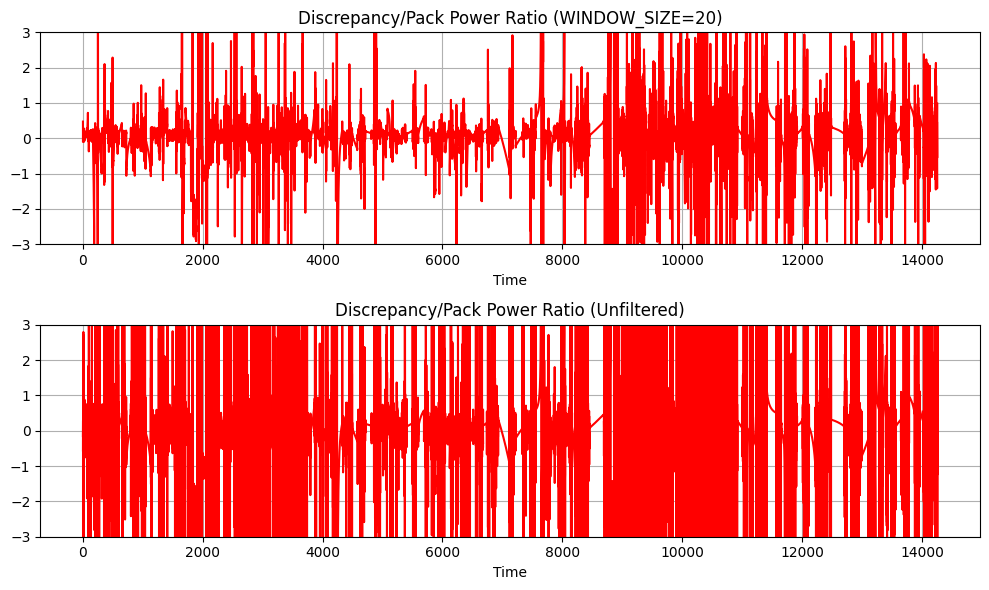

Mean Discrepancy/PackPower Ratio (Filtered):  0.05425379241179022
Mean Discrepancy/PackPower Ratio (Uniltered):  4.5240743385484326


In [9]:
# Butterworth low-pass filter design
def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = signal.filtfilt(b, a, data)  # Zero-phase filtering to avoid phase shift
    return y

# Parameters for the low-pass filter
cutoff_freq = 0.05  # Lower cutoff frequency to filter out more peaks
sampling_rate = 1.0  
filter_order = 6  # Increase filter order to make the cutoff sharper

# Power threshold for filters
threshold = 10
mask = (np.abs(discrepancy) > threshold) & (np.abs(filtered_pack_power) > threshold)

# Create a figure with two subplots (1 row, 2 columns)
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# Filtered ratio between pack power and discrepancy
raw_ratio = discrepancy[np.where(mask)] / filtered_pack_power[np.where(mask)]

# Apply the low-pass filter to the ratio
smoothed_ratio = butter_lowpass_filter(raw_ratio, cutoff_freq, sampling_rate, filter_order)

# Plot the smoothed ratio
ax[0].plot(filtered_pack_power.x_axis[np.where(mask)], smoothed_ratio, color='red')
ax[0].set_title(f'Discrepancy/Pack Power Ratio (WINDOW_SIZE={WINDOW_SIZE})')
ax[0].set_xlabel('Time')
ax[0].grid(True)
ax[0].set_ylim(-3, 3)

# Unfiltered ratio between pack power and discrepancy
aligned_motor_power, aligned_array_power = TimeSeries.align(motor_power, array_power)
unfiltered_deficit = aligned_motor_power - aligned_array_power
aligned_pack_power, unfiltered_deficit = TimeSeries.align(pack_power, unfiltered_deficit)
unfiltered_discrepancy = aligned_pack_power - unfiltered_deficit

# Apply the same epsilon threshold to unfiltered pack power
ax[1].plot(aligned_pack_power.x_axis, (unfiltered_discrepancy / aligned_pack_power), color='red')
ax[1].set_title('Discrepancy/Pack Power Ratio (Unfiltered)')
ax[1].set_xlabel('Time')
ax[1].grid(True)
ax[1].set_ylim(-3, 3)

# Plot style
plt.tight_layout()

# Show the plots
plt.show()

print("Mean Discrepancy/PackPower Ratio (Filtered): ", np.mean(smoothed_ratio))
print("Mean Discrepancy/PackPower Ratio (Uniltered): ", np.mean(unfiltered_discrepancy / aligned_pack_power))

**Ratio** between **array power** and **discrepancy**, filtered and unfiltered

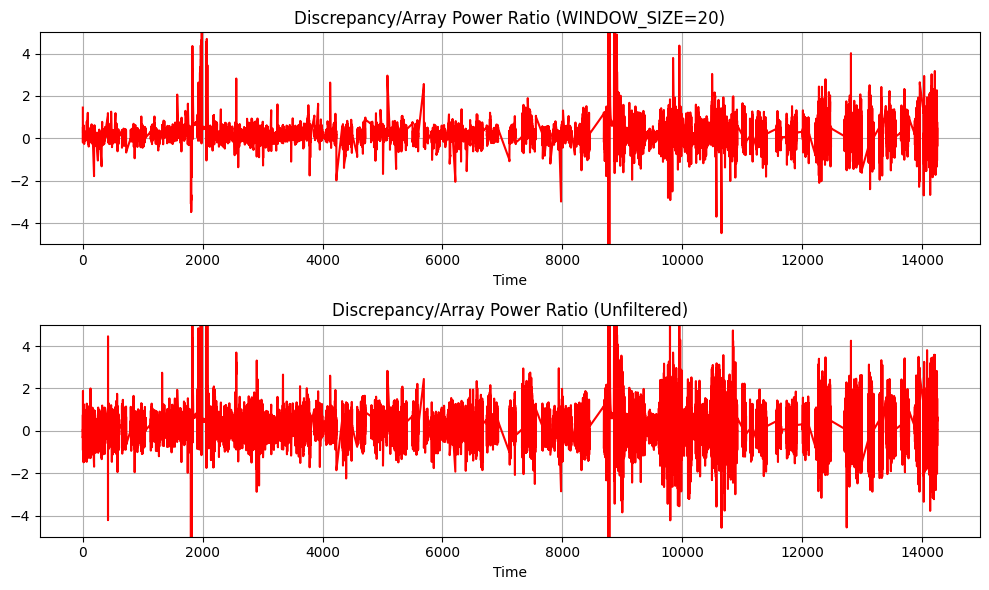

Mean Discrepancy/ArrayPower Ratio (Filtered):  0.17887966270844932
Mean Discrepancy/ArrayPower Ratio (Uniltered):  0.17478895401632882


In [11]:
# Create a figure with two subplots (1 row, 2 columns)
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# Filtered ratio between pack power and discrepancy
aligned_discrepancy, algn_filt_array_pwr = TimeSeries.align(discrepancy, filtered_array_power)
ax[0].plot(algn_filt_array_pwr.x_axis, (aligned_discrepancy/algn_filt_array_pwr), color='red')
ax[0].set_title(f'Discrepancy/Array Power Ratio (WINDOW_SIZE={WINDOW_SIZE})')
ax[0].set_xlabel('Time')
ax[0].grid(True)
ax[0].set_ylim(-5,5)


# # Unfiltered ratio between pack power and discrepancy
aligned_motor_power, aligned_array_power = TimeSeries.align(motor_power, array_power)
unfiltered_deficit = aligned_motor_power - aligned_array_power
aligned_pack_power, unfiltered_deficit = TimeSeries.align(pack_power, unfiltered_deficit)
unfiltered_discrepancy = aligned_pack_power - unfiltered_deficit
aligned_array_power, unfiltered_discrepancy = TimeSeries.align(aligned_array_power, unfiltered_discrepancy)

ax[1].plot(aligned_array_power.x_axis, (unfiltered_discrepancy/aligned_array_power), color='red')
ax[1].set_title('Discrepancy/Array Power Ratio (Unfiltered)')
ax[1].set_xlabel('Time')
ax[1].grid(True)
ax[1].set_ylim(-5,5)


# Plot style
plt.tight_layout()

# Show the plots
plt.show()

print("Mean Discrepancy/ArrayPower Ratio (Filtered): ", np.mean(aligned_discrepancy/algn_filt_array_pwr))
print("Mean Discrepancy/ArrayPower Ratio (Uniltered): ", np.mean(unfiltered_discrepancy/aligned_array_power))


**Integrate discrepency** and compare it to integral of **pack power**, filtered and unfiltered

In [12]:
# Filtered
integ_discrepancy = np.trapz(discrepancy)
integ_filt_pack_power = np.trapz(filtered_pack_power)
print("FILTERED integral comparison ----------------------")
print("Integral of Discrepancy: ", integ_discrepancy)
print("Integral of Pack Power: ", integ_filt_pack_power)
print("Difference (Pack Power - Discrepancy): " , integ_filt_pack_power - integ_discrepancy)


# Unfiltered
integ_unfilt_discrepancy = np.trapz(unfiltered_discrepancy)
integ_unfilt_pack_power = np.trapz(pack_power)
print("\nUNFILTERED integral comparison ----------------------")
print("Integral of Discrepancy: ", integ_unfilt_discrepancy)
print("Integral of Pack Power: ", integ_unfilt_pack_power)
print("Difference (Pack Power - Discrepancy): " , integ_unfilt_pack_power - integ_unfilt_discrepancy)

FILTERED integral comparison ----------------------
Integral of Discrepancy:  16682529.385087615
Integral of Pack Power:  117802545.17842329
Difference (Pack Power - Discrepancy):  101120015.79333568

UNFILTERED integral comparison ----------------------
Integral of Discrepancy:  16681376.665659048
Integral of Pack Power:  117802826.3760803
Difference (Pack Power - Discrepancy):  101121449.71042126


C:\Users\tamze\AppData\Local\Temp\ipykernel_20876\3836147687.py:2: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ_discrepancy = np.trapz(discrepancy)
C:\Users\tamze\AppData\Local\Temp\ipykernel_20876\3836147687.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ_filt_pack_power = np.trapz(filtered_pack_power)
C:\Users\tamze\AppData\Local\Temp\ipykernel_20876\3836147687.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ_unfilt_discrepancy = np.trapz(unfiltered_discrepancy)
C:\Users\tamze\AppData\Local\Temp\ipykernel_20876\3836147687.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integ_unfilt_pack_powe